In [ ]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table align="left">

  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/notebook_template.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-managed-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/workbench/spark/spark_ml.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>                                                                                               
</table>

## Overview

This notebook tutorial shows you Apache SparkML jobs with Dataproc and BigQuery. Through this notebook, you can learn a common use case in the machine learning pipeline: ingestion, data cleaning, feature engineering, modeling, and evaluation.

### Dataset

The two datasets, [NYC TLC (Taxi and Limousine Commission) Trips](https://console.cloud.google.com/marketplace/product/city-of-new-york/nyc-tlc-trips) dataset and [NYC Citi Bike Trips](https://console.cloud.google.com/marketplace/product/city-of-new-york/nyc-citi-bike) dataset, are available in [BigQuery Public Datasets](https://cloud.google.com/bigquery/public-data), and provides free querying of up to 1TB of data each month. It contains trips data for each Taxi and Citi Bike, the public bicycle sharing system serving New York City.

### Objective

This notebook tutorial runs an Apache SparkML job that fetches data from the BigQuery dataset, performs exploratory data analysis, cleans data, executes feature engineering, trains the model, evaluates the model, debriefs for the result and saves the model to a Cloud Storage bucket.

This notebook tutorial performs the following steps:

- Setting up a Google Cloud project and Dataproc cluster.
- Creating a Cloud Storage bucket and a BigQuery dataset.
- Configuring the spark-bigquery-connector.
- Ingesting data from BigQuery into a Spark DataFrame.
- Performing Exploratory Data Analysis (EDA).
- Visualizing data with samples.
- Cleaning data.
- Selecting features.
- Training the model.
- Debriefing the result
- Saving the model to a Cloud Storage bucket.
- Deleting the resources created for this notebook tutorial.

### Costs 

This tutorial uses billable components of Google Cloud:

* [Vertex AI](https://cloud.google.com/vertex-ai/pricing)
* [Cloud Storage](https://cloud.google.com/storage/pricing)
* [Dataproc](https://cloud.google.com/dataproc/pricing)
* [BigQuery](https://cloud.google.com/bigquery/pricing)

You can use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Before you begin

### Set up your Google Cloud project:

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you create an account, you receive a $300 credit towards to your compute and storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the BigQuery API, Notebooks API, Vertex AI API, and Dataproc API](https://console.cloud.google.com/flows/enableapi?apiid=bigquery.googleapis.com,notebooks.googleapis.com,aiplatform.googleapis.com,dataproc&_ga=2.209429842.1903825585.1657549521-326108178.1655322249)

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and inserts the value of Python variables prefixed with `$` into the commands.

### Installation

Install the following packages to run this notebook.

In [57]:
import os

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

USER_FLAG = ""
# Google Cloud Notebook requires dependencies to be installed with '--user'
if IS_GOOGLE_CLOUD_NOTEBOOK:
    USER_FLAG = "--user"

In [58]:
if os.getenv("IS_TESTING"):
    """
    The testing suite does not currently support testing on Dataproc clusters,
    so the testing environment is setup to replicate Dataproc via the following steps.
    """
    JAVA_VER = "8u332-b09"
    JAVA_FOLDER = "/tmp/java"
    FILE_NAME = f"openlogic-openjdk-{JAVA_VER}-linux-x64"
    TAR_FILE = f"{JAVA_FOLDER}/{FILE_NAME}.tar.gz"
    DOWNLOAD_LINK = f"https://builds.openlogic.com/downloadJDK/openlogic-openjdk/{JAVA_VER}/openlogic-openjdk-{JAVA_VER}-linux-x64.tar.gz"
    PYSPARK_VER = "3.1.3"

    # Download Open JDK 8. Spark requires Java to execute.
    ! rm -rf $JAVA_FOLDER
    ! mkdir $JAVA_FOLDER
    ! wget -P $JAVA_FOLDER $DOWNLOAD_LINK
    os.environ["JAVA_HOME"] = f"{JAVA_FOLDER}/{FILE_NAME}"
    ! tar -zxf $TAR_FILE -C $JAVA_FOLDER
    ! echo $JAVA_HOME

    # Pin the Spark version to match that the Dataproc 2.0 cluster.
    ! pip install {USER_FLAG} pyspark==$PYSPARK_VER -q

    # Install GeoPandas.
    ! pip install {USER_FLAG} geopandas -q

    # Install PyArrow.
    ! pip install {USER_FLAG} pyarrow -q

    # Install rtree.
    ! pip install {USER_FLAG} rtree -q

    # Install seaborn.
    ! pip install {USER_FLAG} seaborn -q

### Create a Dataproc cluster

The Spark job executed in this notebook tutorial is compute intensive. Since the job can take a significant amount time to complete in a standard notebook environment, this notebook tutorial runs on a Dataproc cluster that is created with the Dataproc Component Gateway and Jupyter component installed on the cluster.

**Existing Dataproc with Jupyter cluster?**: If you have a running Dataproc cluster that has the [Component Gateway and Jupyter component installed on the cluster](https://cloud.google.com/dataproc/docs/concepts/components/jupyter#gcloud-command)), you can use it in this tutorial. If you plan to use it, skip this step, and go to `Switch your kernel`.

In [59]:
if not os.getenv("IS_TESTING"):
    CLUSTER_NAME = "[your-cluster]"  # @param {type: "string"}
    CLUSTER_REGION = "[your-region]"  # @param {type: "string"}

    if CLUSTER_REGION == "[your-region]":
        CLUSTER_REGION = "us-central1"

    print(f"CLUSTER_NAME: {CLUSTER_NAME}")
    print(f"CLUSTER_REGION: {CLUSTER_REGION}")

CLUSTER_NAME: [your-cluster]
CLUSTER_REGION: us-central1


Your `CLUSTER_NAME` must be **unique within your Google Cloud project**. It must start with a lowercase letter, followed by up to 51 lowercase letters, numbers, and hyphens, and cannot end with a hyphen.

In [60]:
if not os.getenv("IS_TESTING"):
    !gcloud dataproc clusters create $CLUSTER_NAME \
        --region=$CLUSTER_REGION \
        --enable-component-gateway \
        --image-version=2.0 \
        --optional-components=JUPYTER

ERROR: (gcloud.dataproc.clusters.create) PERMISSION_DENIED: Request had insufficient authentication scopes.
- '@type': type.googleapis.com/google.rpc.ErrorInfo
  domain: googleapis.com
  metadata:
    method: google.cloud.dataproc.v1.ClusterController.CreateCluster
    service: dataproc.googleapis.com
  reason: ACCESS_TOKEN_SCOPE_INSUFFICIENT

If you are in a compute engine VM, it is likely that the specified scopes during VM creation are not enough to run this command.
See https://cloud.google.com/compute/docs/access/service-accounts#accesscopesiam for more information about access scopes.
See https://cloud.google.com/compute/docs/access/create-enable-service-accounts-for-instances#changeserviceaccountandscopes for how to update access scopes of the VM.


#### Switch your kernel

Your notebook kernel is listed at the top of the notebook page. Your notebook should run on the Python 3 kernel running on your Dataproc cluster.

Select **Kernel > Change Kernel** from the top menu, then select `Python 3 on CLUSTER_NAME: Dataproc cluster in REGION (Remote)`.

### Set your project ID

Run the following cell to get your project ID.

In [61]:
import os

PROJECT_ID = ""

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

Project ID:  dasi22


If the previous command has no output, copy your project ID from the project selector in the [Google Cloud console](https://console.cloud.google.com/). Insert the ID in the `[your-project-id]` placeholder, then run the following command.

In [62]:
if not PROJECT_ID or PROJECT_ID == "":
    PROJECT_ID = "[your-project-id]"  # @param {type: "string"}

In [63]:
! gcloud config set project $PROJECT_ID -q

Updated property [core/project].


### Create a Cloud Storage bucket

The machine learning model created in this tutorial is stored in Cloud Storage bucket.

#### Region

Before creating a Cloud Storage bucket, re-define the `REGION` variable (when you changed the notebook kernel earlier, previously set variables were deleted).

In [64]:
REGION = "[your-region]"  # @param {type: "string"}

# If you do not specify a region, it will be "us-central1".
if not REGION or REGION == "" or REGION == "[your-region]":
    REGION = "us-central1"

#### UUID

To avoid name collisions, you can create a UUID for the current notebook session, then append the UUID to the name of resources such as the Cloud Storage bucket and BigQuery dataset that you create in this tutorial.

In [65]:
import random
import string


# Generate a uuid of a specifed length(default=8)
def generate_uuid(length: int = 8) -> str:
    return "".join(random.choices(string.ascii_lowercase + string.digits, k=length))


UUID = generate_uuid()

Replace the `[your-bucket-name]` placeholder with the name of your Cloud Storage bucket. The name must be unique across all Cloud Storage buckets.

In [66]:
BUCKET_NAME = "[your-bucket-name]"  # @param {type:"string"}
BUCKET_URI = f"gs://{BUCKET_NAME}/"

# If you do not specify a bucket name, it will be created based on your project ID and the UUID.
if not BUCKET_NAME or BUCKET_NAME == "" or BUCKET_NAME == "[your-bucket-name]":
    BUCKET_NAME = f"{PROJECT_ID}{UUID}"
    BUCKET_URI = f"gs://{BUCKET_NAME}/"

In [67]:
! gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI

Creating gs://dasi22aphxhguu/...


Confirm your access to the Cloud Storage bucket by displaying the bucket's metadata:

In [68]:
! gsutil ls -L -b $BUCKET_URI

gs://dasi22aphxhguu/ :
	Storage class:			STANDARD
	Location type:			region
	Location constraint:		US-CENTRAL1
	Versioning enabled:		None
	Logging configuration:		None
	Website configuration:		None
	CORS configuration: 		None
	Lifecycle configuration:	None
	Requester Pays enabled:		None
	Labels:				None
	Default KMS key:		None
	Time created:			Thu, 11 Aug 2022 21:31:57 GMT
	Time updated:			Thu, 11 Aug 2022 21:31:57 GMT
	Metageneration:			1
	Bucket Policy Only enabled:	True
	Public access prevention:	inherited
	ACL:				[]
	Default ACL:			[]


## Tutorial

### Import required libraries

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from geopandas import gpd
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
# A Spark Session is how you interact with Spark SQL to create Dataframes
from pyspark.sql import SparkSession
# PySpark functions
from pyspark.sql.functions import (col, floor, pandas_udf, to_timestamp, udf,
                                   unix_timestamp)
# These allow us to create a schema for our data
from pyspark.sql.types import BooleanType, DoubleType
from shapely.geometry import Point

### Initialize the SparkSession

To use Apache Spark with BigQuery, you must include the [spark-bigquery-connector](https://github.com/GoogleCloudDataproc/spark-bigquery-connector) when you initialize the SparkSession.

In [70]:
VER = "0.26.0"
FILE_NAME = f"spark-bigquery-with-dependencies_2.12-{VER}.jar"

if os.getenv("IS_TESTING"):
    connector = f"https://github.com/GoogleCloudDataproc/spark-bigquery-connector/releases/download/{VER}/{FILE_NAME}"
else:
    connector = f"gs://spark-lib/bigquery/{FILE_NAME}"


"""
Initialize the "SparkSession" with the following config. 
"viewsEnabled" and "materializationDataset" are required to enable to query data in spark-bigquery-connector.
For more information, check https://github.com/GoogleCloudDataproc/spark-bigquery-connector#reading-data-from-a-bigquery-query.
"""
spark = (
    SparkSession.builder.appName("spark-bigquery-polyglot-language-demo")
    .config("spark.jars", connector)
    .getOrCreate()
)

### Fetch data from BigQuery

In this tutorial, NYC Taxi dataset is in 2017 and NYC Citi Bike dataset is in between 2013 and 2018. Since their time range are different, match both datasets.

In [71]:
# Load NYC_taxi in Github Activity Public Dataset from BigQuery.
taxi_df = (
    spark.read.format("bigquery")
    .option("table", "bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2017")
    .load()
)


# Load NYC_Citibike in Github Acitivity Public dataset from BQ.
bike_df = (
    spark.read.format("bigquery")
    .option("table", "bigquery-public-data.new_york_citibike.citibike_trips")
    .load()
)

Use of `to_timestamp()` and `unix_timestamp()` function to convert `starttime` and `stoptime` as a Unix Timestamp type.

Unix time is a way of representing time as the number of seconds since `January 1st, 1970 at 00:00:00 UTC`. Compared to the Timestamp type, Unix time can be represented as an integer, making it easier to parse and use across different systems.

In [72]:
# Represents 2017-01-01 00:00:00
START_2017 = 1483228800
# Represents 2017-12-31 23:59:59
END_2017 = 1514764799

# Convert the type of starttime from a string to a Unix timestamp.
bike_df = bike_df.withColumn(
    "starttime", unix_timestamp(to_timestamp(col("starttime")))
)

# Convert the type of stoptime from a string to a Unix timestamp.
bike_df = bike_df.withColumn("stoptime", unix_timestamp(to_timestamp(col("stoptime"))))

# Filter data that bike_df only contains trips happended in 2017.
bike_df = bike_df.where(
    (col("starttime") >= START_2017)
    & (col("starttime") <= END_2017)
    & (col("stoptime") >= START_2017)
    & (col("stoptime") <= END_2017)
)

"""
Although this is not a standard practice in a production environment, only 20% of the data for 
the Citi Bike dataset will be used in this project since it consumes too much time and computing resources. 
You can try different values or remove the following line, 
but the runtime of the notebook linearly scales with the size of data.
"""
bike_df = bike_df.sample(0.2)

if os.getenv("IS_TESTING"):
    taxi_df = taxi_df.sample(0.0001)
    bike_df = bike_df.sample(0.0001)

### Perform Exploratory Data Analysis (EDA)

When you get started with a new problem, the first step is to gain an understanding of what the dataset contains. EDA is used to derive insights from the data. Data scientists and analysts try to find different patterns, relations, and anomalies in the data using some statistical graphs and other visualization techniques. It allows analysts to understand the data better before making any assumptions.

Check the data types for Taxi dataset first.

In [73]:
taxi_df.printSchema()

root
 |-- vendor_id: string (nullable = false)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- rate_code: string (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: decimal(38,9) (nullable = true)
 |-- fare_amount: decimal(38,9) (nullable = true)
 |-- extra: decimal(38,9) (nullable = true)
 |-- mta_tax: decimal(38,9) (nullable = true)
 |-- tip_amount: decimal(38,9) (nullable = true)
 |-- tolls_amount: decimal(38,9) (nullable = true)
 |-- ehail_fee: decimal(38,9) (nullable = true)
 |-- total_amount: decimal(38,9) (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- distance_between_service: decimal(38,9) (nullable = true)
 |-- time_between_service: long (nullable = true)
 |-- trip_type: string (nullable = true)
 |-- imp_surcharge: decimal(38,9) (nullable = true)
 |-- pickup_location_id: string (nullable = true)
 |-- dropoff_location_id:

Filter out unnecessary columns and check null counts of the fields. Note that `pickup_location_id` and `dropoff_location_id` are string format when it was converted from the BigQuery dataset. To use it effectively, it needs to be re-formatted.

In [74]:
taxi_df = taxi_df.select(
    "pickup_datetime",
    "dropoff_datetime",
    "trip_distance",
    "fare_amount",
    col("pickup_location_id").cast("int").alias("start_zone_id"),
    col("dropoff_location_id").cast("int").alias("end_zone_id"),
)

taxi_df.describe().show()
taxi_df.show()

+-------+-----------------+-----------------+------------------+------------------+
|summary|    trip_distance|      fare_amount|     start_zone_id|       end_zone_id|
+-------+-----------------+-----------------+------------------+------------------+
|  count|         11737048|         11737048|          11737048|          11737048|
|   mean|  2.6844619100000| 11.7951208590000|111.88188614377312|129.04863147871595|
| stddev|2.828483059700814|9.875489157593911| 75.87760092760986|   77.231870355259|
|    min|             0E-9|   -480.000000000|                 1|                 1|
|    max|    640.000000000|   6003.500000000|               265|               265|
+-------+-----------------+-----------------+------------------+------------------+

+-------------------+-------------------+-------------+------------+-------------+-----------+
|    pickup_datetime|   dropoff_datetime|trip_distance| fare_amount|start_zone_id|end_zone_id|
+-------------------+-------------------+------------

From this summary, you are able to know a lot of information.
  * There are over 11 millions of trip history for Green Taxi in 2017. but it has some abnormal values such as negative values in it.
  * Until 2016, the exact latitude and longitude were used for the pickup and the dropoff locations. It raised a lot of [privacy concerns](https://agkn.wordpress.com/2014/09/15/riding-with-the-stars-passenger-privacy-in-the-nyc-taxicab-dataset/) and the dataset has been providing `pickup_location_id` and `dropoff_location_id` instead. This id is corresponded to the [NYC Taxi Zones](https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc), roughly based on NYC Department of City Planning’s Neighborhood Tabulation Areas (NTAs) and are meant to approximate neighborhoods.

Based on numbers shown above, filter out some unrealistic values.
  * Every row contains null values must be removed.
  * trip_distance must be in between 0 and 20 (miles) since the length of Manhattan is about 13.4 miles long.
  * fare_amount must be in between 0 and 500 (dollars) since it does not include taxes and tips.

In [75]:
taxi_df = taxi_df.where(
    (col("trip_distance") > 0)
    & (col("trip_distance") < 20)
    & (col("fare_amount") > 0)
    & (col("fare_amount") < 500)
).dropna()

Use of `unix_timestamp()` function to convert `pickup_datetime` and `dropoff_datetime` as a Unix Timestamp type.

After you get `start_time` and `end_time` by converting the original `pickup_datetime` and `dropoff_datetime`, you are able to get more insteresting columns manipulating these two Timestamps.

In [76]:
# Convert the type of datetime from a string to a Unix timestamp.
taxi_df = taxi_df.withColumn("start_time", unix_timestamp(col("pickup_datetime")))
taxi_df = taxi_df.withColumn("end_time", unix_timestamp(col("dropoff_datetime")))

# Calculate if this is a weekday
taxi_df = taxi_df.withColumn(
    "is_weekday",
    ((floor(col("start_time") / 86400) + 4) % 7 > 0)
    & ((floor(col("start_time") / 86400) + 4) % 7 < 6),
)

# Convert start_time to start_time_in_minute.
taxi_df = taxi_df.withColumn(
    "start_time_in_hour", floor((col("start_time") % 86400) / 60 / 60)
)

# Calculate trip_duration.
taxi_df = taxi_df.withColumn("trip_duration", col("end_time") - col("start_time"))

### Perform Feature Engineering

The Taxi dataset contains trips among every boroughs in NYC, while the Citi Bike dataset has trips in between Manhattan and some part of Brooklyn and Bronx. To match the location, filter out the other boroughs except Manhattan.

To convert the location id to the borough, download the GeoJSON format from the NYC OpenData.

In [77]:
# Load the GeoJSON format of NYC Taxi zones.
gdf_zone = gpd.read_file(
    "https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=GeoJSON"
)

# Convert the type of "location_id" column.
gdf_zone["location_id"] = gdf_zone["location_id"].astype("long")

# Convert GeoPandas format to a dictionary.
hm = gdf_zone.to_dict("index")

# Create a set that contains location_id if the location is in Manhattan.
manhattan_set = {hm[i]["location_id"] for i in hm if hm[i]["borough"] == "Manhattan"}


@udf(returnType=BooleanType())
def is_in_manhattan(location_id):
    """
    The preprocessing function takes location_id and returns whether the given location_id is in the manhattan_set.
    Args:
        location_id: A number from 0 to 263 that represents NYC Taxi Zone.
    Returns:
        A Boolean value of whether the given location_id is in the manhattan_set.
    """
    return location_id in manhattan_set

In [78]:
# Trips must done within the Manhattan and between different taxi zones.
taxi_df = taxi_df.where(
    (col("start_zone_id") != col("end_zone_id"))
    & (is_in_manhattan(col("start_zone_id")))
    & (is_in_manhattan(col("end_zone_id")))
)

In [79]:
taxi_df.show()
taxi_df.describe().show()

+-------------------+-------------------+-------------+------------+-------------+-----------+----------+----------+----------+------------------+-------------+
|    pickup_datetime|   dropoff_datetime|trip_distance| fare_amount|start_zone_id|end_zone_id|start_time|  end_time|is_weekday|start_time_in_hour|trip_duration|
+-------------------+-------------------+-------------+------------+-------------+-----------+----------+----------+----------+------------------+-------------+
|2017-01-01 00:09:54|2017-01-01 00:54:40|  4.500000000|28.000000000|          236|         68|1483229394|1483232080|     false|                 0|         2686|
|2017-01-01 00:21:45|2017-01-01 00:46:21|  8.570000000|28.000000000|           41|        232|1483230105|1483231581|     false|                 0|         1476|
|2017-01-01 00:46:57|2017-01-01 01:17:37|  6.700000000|24.500000000|          243|         75|1483231617|1483233457|     false|                 0|         1840|
|2017-01-01 00:29:51|2017-01-01 00

+-------+------------------+-----------------+-----------------+------------------+-------------------+--------------------+------------------+------------------+
|summary|     trip_distance|      fare_amount|    start_zone_id|       end_zone_id|         start_time|            end_time|start_time_in_hour|     trip_duration|
+-------+------------------+-----------------+-----------------+------------------+-------------------+--------------------+------------------+------------------+
|  count|           2844580|          2844580|          2844580|           2844580|            2844580|             2844580|           2844580|           2844580|
|   mean|   2.2534914290000| 10.4584453210000|95.93003993559682|136.03869464033355|1.498310880016864E9|1.4983119031243541E9|13.929313290538499|1023.1074900336781|
| stddev|1.8394190788261384|6.124934556427761|62.44357580633429| 79.48560018212322|  9132043.235551724|    9132059.60746184| 5.446451682345288| 5122.580806257516|
|    min|       0.0100

Prior to visualizing this modified Taxi dataset, do similar feature engineering for the Citi Bike dataset.

In [80]:
bike_df.printSchema()
bike_df.describe().show()

root
 |-- tripduration: long (nullable = true)
 |-- starttime: long (nullable = true)
 |-- stoptime: long (nullable = true)
 |-- start_station_id: long (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: double (nullable = true)
 |-- start_station_longitude: double (nullable = true)
 |-- end_station_id: long (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: double (nullable = true)
 |-- end_station_longitude: double (nullable = true)
 |-- bikeid: long (nullable = true)
 |-- usertype: string (nullable = true)
 |-- birth_year: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- customer_plan: string (nullable = true)



+-------+------------------+--------------------+-------------------+------------------+------------------+----------------------+-----------------------+------------------+----------------+--------------------+---------------------+-----------------+----------+------------------+-------+-------------+
|summary|      tripduration|           starttime|           stoptime|  start_station_id|start_station_name|start_station_latitude|start_station_longitude|    end_station_id|end_station_name|end_station_latitude|end_station_longitude|           bikeid|  usertype|        birth_year| gender|customer_plan|
+-------+------------------+--------------------+-------------------+------------------+------------------+----------------------+-----------------------+------------------+----------------+--------------------+---------------------+-----------------+----------+------------------+-------+-------------+
|  count|           2822304|             2822304|            2822304|           2822304|

From this summary, there is also interesting information from the dataset's summary.
  * There are over 2.8 million logs of trips for Citi Bike in 2017.
  * The current dataset has some abnormal values.
  * `starttime` and `stoptime` are string format. To use it effectively, it needs to be re-formatted.
  * The Citi Bike dataset have no `location_id` for NYC Taxi Zones but the coordinates data. To convert the coordinates to the NYC Taxi Zones, Pandas UDF, as known as Vectorized UDF feature is used. For more information, [check this link](https://www.databricks.com/blog/2017/10/30/introducing-vectorized-udfs-for-pyspark.html).

In [81]:
@pandas_udf("long")
def preprocess_zone_id(lat: pd.Series, lon: pd.Series) -> pd.Series:
    """
    The preprocessing function takes latitudes and longitudes and returns the corresponding Taxi Zone id.
    Args:
        lat: The latitude of the position.
        lon: The longitude of the position.
    Returns:
        The Taxi Zone id.
    """
    point_var = [Point(xy) for xy in zip(lon, lat)]
    gdf_points = gpd.GeoDataFrame(
        pd.DataFrame({"lat": lat, "lon": lon}), crs="epsg:4326", geometry=point_var
    )
    gdf_joined = gpd.sjoin(gdf_points, gdf_zone, how="left")
    return gdf_joined["location_id"]

In [82]:
# Rename "tripduration" to "trip_duration".
bike_df = bike_df.withColumnRenamed("tripduration", "trip_duration")

# Check whether the starttime is a weekday or a weekend.
bike_df = bike_df.withColumn(
    "is_weekday",
    ((floor(col("starttime") / 86400) + 4) % 7 > 0)
    & ((floor(col("starttime") / 86400) + 4) % 7 < 6),
)

# Convert starttime to start_time_in_minute
bike_df = bike_df.withColumn(
    "start_time_in_hour", floor((col("starttime") % 86400) / 60 / 60)
)

# Add "start_zone_id" and "end_zone_id" by applying the UDF "preprocess_zone_id".
bike_df = bike_df.withColumn(
    "start_zone_id",
    preprocess_zone_id(
        bike_df["start_station_latitude"], bike_df["start_station_longitude"]
    ),
)
bike_df = bike_df.withColumn(
    "end_zone_id",
    preprocess_zone_id(
        bike_df["end_station_latitude"], bike_df["end_station_longitude"]
    ),
)

# Filter out the bike_df by the following conditions
# Trips must done between different taxi zones.
# The start time must be earlier than the end time.
# Trips must start and end within the Manhattan
bike_df = bike_df.where(
    (col("start_zone_id") != col("end_zone_id"))
    & (col("starttime") < col("stoptime"))
    & (is_in_manhattan(col("start_zone_id")))
    & (is_in_manhattan(col("end_zone_id")))
)

bike_df = bike_df.select(
    "trip_duration",
    "starttime",
    "stoptime",
    "start_station_latitude",
    "start_station_longitude",
    "end_station_latitude",
    "end_station_longitude",
    "usertype",
    "start_zone_id",
    "end_zone_id",
    "is_weekday",
    "start_time_in_hour",
)

Assume that the Citi Bike users move through the Manhattan's roads, which are the perfectly perpendicular streets, the trip distance can be calculated by applying the [Manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry).

To Calulate the Manhattan distance, assume that you are in the **W 15th St and 9th Ave, where Google NYC is located,** and you want to go to **W 33rd St and 5th Ave, where the Empire State building is located**. In a full of city blocks, the fastest way you can get to the destination is to move east until you reached the 5th Avenue, and move north until you reached the W 33rd St. In this case, **W 16th St and 5th Ave** or **W 33rd St and 9th Ave** can be a hinge point. If we set the starting point as **S**, the ending point as **E**, and the hinge point as **H**, the formula of Manhattan distance is `distance(S, H) + distance(H, E)`.

However, in a real world, it requires more calculation to get the "real" Manhattan distance. First of all, unlike the Cartesian coordinate system. the actual distance in longitude varies with latitude. For example, 1 degree of longitude represents roughly 69 miles at equator, is the same as latitude, while it is about 49 miles at 45 degrees North or South. To calculate the exact distance in a real world using latitudes and longitudes, [Haversine distance](https://en.wikipedia.org/wiki/Haversine_formula) is one of the good choices.

Furthermore, the streets in Manhattan are inclined at about 29 degrees to the True north, so you should rotate the point S and E by 29 degrees counter-clockwise.

Therefore, the final formula should be `manhattan_distance = haversine_distance(S', H') + haversine_distance(H', E')` where `S'`, `H'`, `E'` are the rotated points.

In [83]:
@udf(returnType=DoubleType())
def manhattan_dist(lat_start, lon_start, lat_end, lon_end):
    """
    The preprocessing function takes latitudes and longitudes of start position and end position,
    and returns the Manhattan distance between them.
    Args:
        lat_start: The latitude of the start position.
        lon_start: The longitude of the start position.
        lat_end: The latitude of the end position.
        lon_end: The longitude of the end position.
    Returns:
        The Manhattan distance between start and end position.
    """
    # Approximate radius of Earth in mile.
    EARTH_RADIUS = 3958.76

    # Approximate inclined degree of the streets in Manhattan.
    THETA = np.radians(-28.904)

    def haversine(pos_start, pos_end):
        """
        The helper function takes start and end position and returns the haversine distance.
        Args:
            pos_start: a latitude and a longitude of start position in np.array form.
            pos_end: a latitude and a longitude of end position in np.array form.
        Returns:
            The Haversine, the spherical distance between pos_start and pos_end on a sphere, in this case, the Earth.
        """
        rad_dist_lat = np.radians(pos_end[0] - pos_start[0])
        rad_dist_lon = np.radians(pos_end[1] - pos_start[1])
        rad_start_lat = np.radians(pos_start[0])
        rad_end_lat = np.radians(pos_end[0])
        dist = 2 * np.arcsin(
            np.sqrt(
                np.sin(rad_dist_lat / 2) ** 2
                + np.cos(rad_start_lat)
                * np.cos(rad_end_lat)
                * np.sin(rad_dist_lon / 2) ** 2
            )
        )
        return EARTH_RADIUS * dist

    def rotate(pos, theta):
        """
        The helper function takes position and the degree theta, and returns rotated position.
        Args:
            pos: a latitude and a longitude of position in np.array form.
            theta: the degree to rotate.
        Returns:
            Rotated position.
        """
        rotate = np.array(
            [[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]]
        )
        return np.matmul(rotate, pos)

    if not (lat_start and lon_start and lat_end and lon_end):
        return -1

    # Convert positions to np.array format.
    start, end = np.array([lat_start, lon_start]), np.array([lat_end, lon_end])

    # Rotate each positions by 29' using a helper function.
    rotated_start, rotated_end = rotate(start, THETA), rotate(end, THETA)

    # Get rotated hinge point using rotated start and end point.
    rotated_hinge = np.array([rotated_start[0], rotated_end[1]])

    # Re-rotate the hinge point.
    hinge = rotate(rotated_hinge, -THETA)

    # Return the sum of the Haversine distance between start and hinge, hinge and end.
    return float(haversine(start, hinge) + haversine(hinge, end))

In [84]:
# Calculate the Manhattan distance between "start_station" and "end_station".
bike_df = bike_df.withColumn(
    "trip_distance",
    manhattan_dist(
        col("start_station_latitude"),
        col("start_station_longitude"),
        col("end_station_latitude"),
        col("end_station_longitude"),
    ),
)

In [85]:
# Filter out the bike_df with the same condition as the taxi_df
bike_df = bike_df.where(
    (col("trip_distance") > 0)
    & (col("trip_distance") < 20)
    & (col("trip_duration") > 0)
    & (col("start_station_latitude") > 40)
    & (col("start_station_latitude") < 41)
    & (col("end_station_latitude") > 40)
    & (col("end_station_latitude") < 41)
    & (col("start_station_longitude") > -75)
    & (col("start_station_longitude") < -73)
    & (col("end_station_longitude") > -75)
    & (col("end_station_longitude") < -73)
)

In [86]:
bike_df.printSchema()

root
 |-- trip_duration: long (nullable = true)
 |-- starttime: long (nullable = true)
 |-- stoptime: long (nullable = true)
 |-- start_station_latitude: double (nullable = true)
 |-- start_station_longitude: double (nullable = true)
 |-- end_station_latitude: double (nullable = true)
 |-- end_station_longitude: double (nullable = true)
 |-- usertype: string (nullable = true)
 |-- start_zone_id: long (nullable = true)
 |-- end_zone_id: long (nullable = true)
 |-- is_weekday: boolean (nullable = true)
 |-- start_time_in_hour: long (nullable = true)
 |-- trip_distance: double (nullable = true)



Check the distributions for the numerical columns. In PySpark, visualizing is expensive because the data is too large. 

For example, the NYC Taxi dataset has more than 10M rows. Therefore, approximately 3% of total data (approx. 330k rows) are extracted as a sample.

In [87]:
%%time
taxi_sample = taxi_df.sample(0.03)
taxi_pd = taxi_sample.toPandas()

# Convert "object" type columns to the float type.
taxi_pd["trip_distance"] = taxi_pd["trip_distance"].astype(float)
taxi_pd["fare_amount"] = taxi_pd["fare_amount"].astype(float)
taxi_pd.info()

bike_sample = bike_df.sample(0.03)
bike_pd = bike_sample.toPandas()
bike_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84727 entries, 0 to 84726
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   pickup_datetime     84727 non-null  datetime64[ns]
 1   dropoff_datetime    84727 non-null  datetime64[ns]
 2   trip_distance       84727 non-null  float64       
 3   fare_amount         84727 non-null  float64       
 4   start_zone_id       84727 non-null  int32         
 5   end_zone_id         84727 non-null  int32         
 6   start_time          84727 non-null  int64         
 7   end_time            84727 non-null  int64         
 8   is_weekday          84727 non-null  bool          
 9   start_time_in_hour  84727 non-null  int64         
 10  trip_duration       84727 non-null  int64         
dtypes: bool(1), datetime64[ns](2), float64(2), int32(2), int64(4)
memory usage: 5.9 MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59658 entries, 0 to 59657
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   trip_duration            59658 non-null  int64  
 1   starttime                59658 non-null  int64  
 2   stoptime                 59658 non-null  int64  
 3   start_station_latitude   59658 non-null  float64
 4   start_station_longitude  59658 non-null  float64
 5   end_station_latitude     59658 non-null  float64
 6   end_station_longitude    59658 non-null  float64
 7   usertype                 59658 non-null  object 
 8   start_zone_id            59658 non-null  int64  
 9   end_zone_id              59658 non-null  int64  
 10  is_weekday               59658 non-null  bool   
 11  start_time_in_hour       59658 non-null  int64  
 12  trip_distance            59658 non-null  float64
dtypes: bool(1), float64(5), int64(6), object(1)
memory usage: 5.5+ MB
CPU times:

Since there are some extreme data points, remove them and bin the data into a box and histogram.

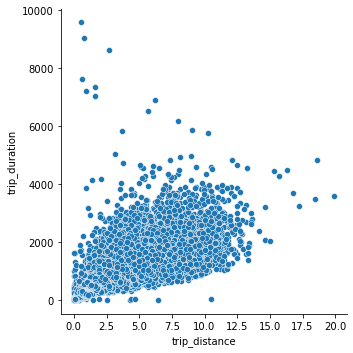

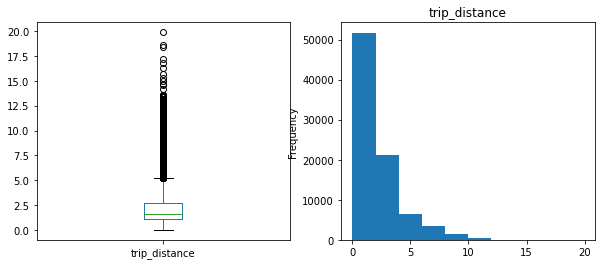

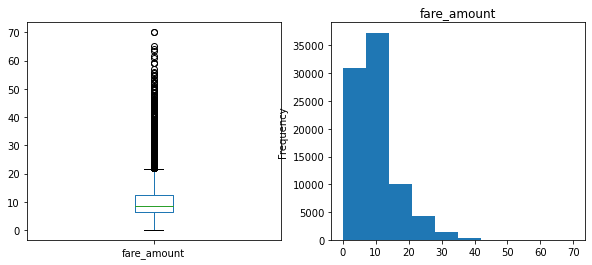

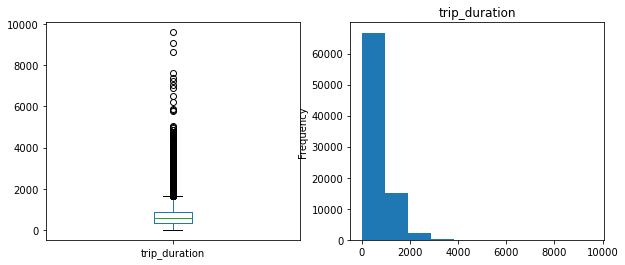

In [88]:
TAXI_COLUMNS_TO_SHOW = {"trip_distance", "trip_duration", "fare_amount"}

taxi_pd_filtered = taxi_pd.query(
    "trip_distance > 0 and trip_distance < 20 \
    and trip_duration > 0 and trip_duration < 10000"
)

sns.relplot(
    data=taxi_pd_filtered,
    x="trip_distance",
    y="trip_duration",
    kind="scatter",
    ci=None,
)

for column in taxi_pd_filtered.columns:
    if column in TAXI_COLUMNS_TO_SHOW:
        _, ax = plt.subplots(1, 2, figsize=(10, 4))
        taxi_pd_filtered[column].plot(kind="box", ax=ax[0])
        taxi_pd_filtered[column].plot(kind="hist", ax=ax[1])
        plt.title(column)
        plt.show()

We found that most columns are skewed right and the trip_distance basically increases as trip_duration increases. Furthermore, most trips are done within an hour (3600 sec).

Do the similar work for the Citi Bike dataset.

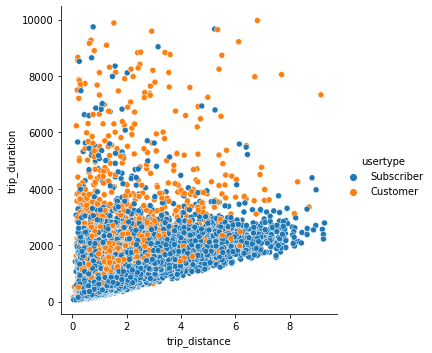

In [89]:
BIKE_COLUMNS_TO_SHOW = {"trip_distance", "trip_duration"}

bike_pd_filtered = bike_pd.query(
    "trip_distance > 0 and trip_distance < 20 \
    and trip_duration > 0 and trip_duration < 10000"
)

sns.relplot(
    data=bike_pd_filtered,
    x="trip_distance",
    y="trip_duration",
    hue="usertype",
    kind="scatter",
    ci=None,
)

The plot for trip_distance and trip_duration for Citi Bike looks different than the same plot for the Taxi dataset.

A lot of trips was longer than expected given the trip distance. The reason for this behavior seems that, unlike taxis, city bike users less likely to have an exact destination of trip, or they did not park their bicycles properly at the station. This behavior is found more on customers, who do not use the Citi Bike regularly.

To remove outliers, let's assume the average bike speed is at least 2 miles per hour, and filter them out if a trip_duration multiplied by speed is less trip_distance, and remove `Customer` user type.

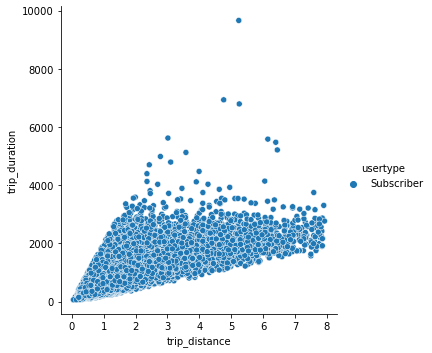

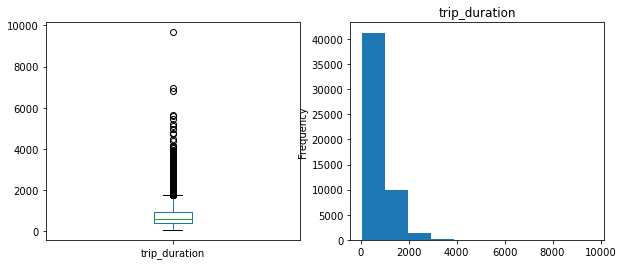

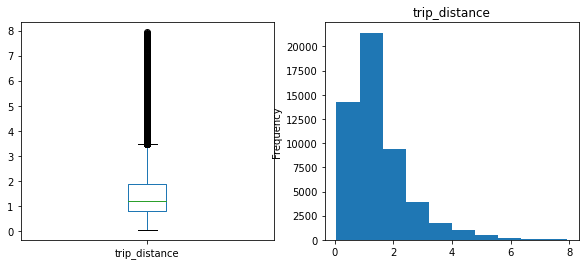

In [90]:
bike_pd_filtered = bike_pd.query(
    "trip_distance > 0 and trip_distance < 8 \
    and (trip_duration * 0.0005) <= trip_distance \
    and trip_duration > 0 and trip_duration < 10000 \
    and usertype=='Subscriber'"
)

sns.relplot(
    data=bike_pd_filtered,
    x="trip_distance",
    y="trip_duration",
    hue="usertype",
    kind="scatter",
    ci=None,
)

for column in bike_pd_filtered.columns:
    if column in BIKE_COLUMNS_TO_SHOW:
        _, ax = plt.subplots(1, 2, figsize=(10, 4))
        bike_pd_filtered[column].plot(kind="box", ax=ax[0])
        bike_pd_filtered[column].plot(kind="hist", ax=ax[1])
        plt.title(column)
        plt.show()

Based on the visualized data, apply filter to remove unrealistic values.

In [91]:
taxi_df = taxi_df.where(
    (col("trip_duration") > 0)
    & (col("trip_duration") < 3600)
    & ((col("trip_duration") * 0.00055) <= col("trip_distance"))
)

bike_df = bike_df.where(
    (col("trip_duration") > 0)
    & (col("trip_duration") < 3600)
    & (col("usertype") == "Subscriber")
    & ((col("trip_duration") * 0.00055) <= col("trip_distance"))
)

### Feature Selection

Not all features in our dataset will be useful. 
Since the purpose of this tutorial is comparing two datasets, we need to use same features for training. There are some useful features for training the Taxi dataset, such as `fare_amount`, since Citi Bike dataset does not have it, it will not be used in this tutorial.

After choose the following columns as features, they needs to be assembled with `VectorAssembler()`, A feature transformer that merges multiple columns into a vector column.

In [92]:
feature_cols = [
    "is_weekday",
    "start_time_in_hour",
    "start_zone_id",
    "end_zone_id",
    "trip_distance",
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Transform each column into the vector form.
taxi_transformed_data = assembler.transform(taxi_df)
bike_transformed_data = assembler.transform(bike_df)

# Split randomly with training and test data.
(taxi_training_data, taxi_test_data) = taxi_transformed_data.randomSplit([0.95, 0.05])
(bike_training_data, bike_test_data) = bike_transformed_data.randomSplit([0.95, 0.05])

### Training the Model

In PySpark, there are several Regression Models provided such as `LinearRegression`, `GeneralizedLinearRegression`, `DecisionTreeRegressor`, `RandomForestRegressor`, and `GBTRegressor`.
`GBTRegressor`, as known as `Gradient Boosted Trees` are a popular regression method using ensembles of decision trees. This algorithm iteratively trains decision trees in order to minimize a loss function.
Although this model is computationally expensive, in testing it was shown that the `GBT Regressor` provides the best results.

In [93]:
# Define GBTRegressor
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="trip_duration",
    predictionCol="pred_trip_duration",
)

# Define evaluator for r2 score.
evaluator_r2 = RegressionEvaluator(
    labelCol=gbt.getLabelCol(), predictionCol=gbt.getPredictionCol(), metricName="r2"
)

# Define evaluator for RMSE error.
evaluator_rmse = RegressionEvaluator(
    labelCol=gbt.getLabelCol(), predictionCol=gbt.getPredictionCol(), metricName="rmse"
)

In [94]:
# Train a model and get predictions for the Taxi dataset. It takes several minutes.
taxi_gbt_model = gbt.fit(taxi_training_data)
taxi_gbt_predictions = taxi_gbt_model.transform(taxi_test_data)

In [95]:
# Train a model and get predictions for the Citi Bike dataset. It takes several minutes.
bike_gbt_model = gbt.fit(bike_training_data)
bike_gbt_predictions = bike_gbt_model.transform(bike_test_data)

In [96]:
# Evaluate the r2 score for the Taxi dataset
taxi_gbt_accuracy_r2 = evaluator_r2.evaluate(taxi_gbt_predictions)
print(f"Taxi Test GBT R2 Accuracy = {taxi_gbt_accuracy_r2}")

# Evaluate the RMSE for the Taxi dataset
taxi_gbt_accuracy_rmse = evaluator_rmse.evaluate(taxi_gbt_predictions)
print(f"Taxi Test GBT RMSE Accuracy = {taxi_gbt_accuracy_rmse}")

Taxi Test GBT R2 Accuracy = 0.7702918281983069


Taxi Test GBT RMSE Accuracy = 228.36210152664106


In [ ]:
# Evaluate the r2 score for the Citi Bike dataset
bike_gbt_accuracy_r2 = evaluator_r2.evaluate(bike_gbt_predictions)
print(f"Bike Test GBT R2 Accuracy = {bike_gbt_accuracy_r2}")

# Evaluate the RMSE for the Citi Bike dataset
bike_gbt_accuracy_rmse = evaluator_rmse.evaluate(bike_gbt_predictions)
print(f"Bike Test GBT RMSE Accuracy = {bike_gbt_accuracy_rmse}")

Bike Test GBT R2 Accuracy = 0.7105076792271336


### Debrief the result

The trained model for the Taxi dataset shows about 77% for r2 score and 230 root-mean square error (RMSE), while the model for the Citi Boke dataset shows about 71% for r2 score and 250 RMSE. There are some restrictions to having relatively lower scores.
* Do not use CrossValidator
  * In real machine learning projects, cross-validation is an essential tool that provides us to utilize our data better. However, it re-run the training algorithm several times so it requres a lot of time and computation resource. For more information, [check this link](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29).
* Do not use every feature in the Taxi dataset.
  * The Taxi dataset has a `fare_amount` column, which has a strong correlation between the label, `trip_duration`. If that column was included, the model for the Taxi dataset shows 90+% r2 score.
  * The reason that the Taxi dataset has limited features is the purpose of this project is to compare Taxi and the Citi Bike.
* Do not use the exact coordinates for both datasets.
  * Due to privacy concerns, Taxi dataset is no longer providing the precise coordination of pickup and dropoff locations, but NYC Taxi zones in recent data.
  * Taxi Zone is a categorical number that does not represents a geographical zone defined by NYC Taxi

### Save the model to a Cloud Storage path

In [ ]:
BUCKET_FOLDER = "/tmp/bucket"

# In the testing environment, saving to GCS bucket routes to the local file system.
if os.getenv("IS_TESTING"):
    ! rm -rf $BUCKET_FOLDER
    ! mkdir $BUCKET_FOLDER
    bike_gbt_model.write().overwrite().save(f"{BUCKET_FOLDER}")
    ! gsutil cp -r $BUCKET_FOLDER $BUCKET_URI
else:
    bike_gbt_model.write().overwrite().save(f"{BUCKET_URI}/")

## Cleaning up

See [Clean up](https://cloud.google.com/vertex-ai/docs/workbench/managed/create-managed-notebooks-instance-console-quickstart#clean-up) to delete your project or the managed notebook created in this tutorial.

### Delete Google Cloud Storage bucket

In [ ]:
! gsutil rm -r $BUCKET_URI

### Delete Dataproc Cluster

It is not possible to delete the cluster you are currently using unless you switch the kernel to local. To delete it, you need to switch the kernel to local `Python 3` or `PySpark`, set your `CLUSTER_NAME` and `CLUSTER_REGION` manually in the following cell, and execute the `gcloud` command.

See [Deleting a cluster](https://cloud.google.com/dataproc/docs/guides/manage-cluster#console) to delete the Dataproc cluster created in this tutorial.

In [ ]:
CLUSTER_NAME = "[your-cluster-name]"
CLUSTER_REGION = "[your-cluster-region]"

In [ ]:
if not os.getenv("IS_TESTING"):
    ! gcloud dataproc clusters delete $CLUSTER_NAME --region=$CLUSTER_REGION -q